# Summary of the NLP Notebook

This notebook performs basic Natural Language Processing (NLP) tasks and Exploratory Data Analysis (EDA) on a text dataset. The main steps are listed in README file.

In [6]:
# Standard Libraries
import os
import re
import string

# Third-Party Libraries
import numpy as np
import pandas as pd
import gensim
import logging
import httpcore
import soundfile as sf
import noisereduce as nr
import moviepy.editor as mp
import speech_recognition as sr
from tqdm import tqdm
from scipy.io import wavfile
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from faster_whisper import WhisperModel

# NLTK Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

# Sklearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Gensim Libraries
from gensim.models import Word2Vec

# Cleantext Libraries
from cleantext.sklearn import CleanTransformer
from cleantext import clean
import cleantext

# Matplotlib Libraries
import matplotlib.pyplot as plt

# Download necessary nltk data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Set logging level for moviepy
logging.getLogger('moviepy').setLevel(logging.CRITICAL)

# Set attribute for httpcore
setattr(httpcore, 'SyncHTTPTransport', 'AsyncHTTPProxy')

# Load the Whisper model
# model = whisper.load_model("large-v3")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felixtong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/felixtong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/felixtong/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/felixtong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# EDA (word count stats)

In [7]:
"""
This Python script processes a directory of text files, counts the number of words in each file, and outputs some statistics.
"""

def count_words_in_file(file_path):
    """
    Counts the number of words in a given text file.

    Args:
        file_path (str): The path to the text file.

    Returns:
        int: The number of words in the text file.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        words = f.read().split()
        return len(words)

def process_directory(directory_path):
    """
    Processes a directory of text files, returning the filenames and their corresponding word counts.

    Args:
        directory_path (str): The path to the directory containing the text files.

    Returns:
        list: A list of filenames.
        list: A list of word counts corresponding to the filenames.
    """
    word_counts = []
    file_names = []
    for root, dirs, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith('.txt'):
                file_path = os.path.join(root, filename)
                word_count = count_words_in_file(file_path)
                word_counts.append(word_count)
                file_names.append(filename)
    return file_names, word_counts

def plot_word_counts(file_names, word_counts):
    """
    Plots a bar chart of word counts for each text file.

    Args:
        file_names (list): A list of filenames.
        word_counts (list): A list of word counts corresponding to the filenames.
    """
    plt.bar(file_names, word_counts)
    plt.title('Word Counts in Text Files')
    plt.xlabel('File Name')
    plt.ylabel('Word Count')
    plt.xticks(rotation=90)
    plt.show()

def output_statistics(word_counts, file_names):
    """
    Outputs statistics about the word counts, including total word count, descriptive statistics, 
    files with word counts below 20, and the top 3 files with the most word counts.

    Args:
        word_counts (list): A list of word counts.
        file_names (list): A list of filenames.
    """
    df = pd.DataFrame({'Word Count': word_counts, 'File Name': file_names})
    total_word_count = df['Word Count'].sum()
    print(f"Total word count across all files: {total_word_count}")
    print(df.describe())

    # Output the file names where the word counts are below 20
    low_count_files = df[df['Word Count'] < 20]['File Name']
    print("\nFiles with word counts below 20:")
    for file in low_count_files:
        print(file)

    # Output the top 3 files with the most word counts
    top_files = df.nlargest(3, 'Word Count')['File Name']
    print("\nTop 3 files with the most word counts:")
    for file in top_files:
        print(file)

# Replace with your directory path
directory_path = '/path/to/your/directory/'  
file_names, word_counts = process_directory(directory_path)
# plot_word_counts(file_names, word_counts)
output_statistics(word_counts, file_names) 


Total word count across all files: 430325
        Word Count
count   990.000000
mean    434.671717
std     529.405896
min       0.000000
25%     120.000000
50%     320.000000
75%     570.500000
max    6249.000000

Files with word counts below 20:
230805_153540_812_FH.txt
230709_141533_089_FH.txt
230709_154538_119_FH.txt
230805_155341_818_FH.txt
230628_170916_237_FH.txt
230628_170616_236_FH.txt
230622_192842_635_FH.txt
230709_153338_115_FH.txt
230709_151237_108_FH.txt
230709_153037_114_FH.txt
230628_171216_238_FH.txt
230805_160241_821_FH.txt
230709_152137_111_FH.txt
230709_152737_113_FH.txt
230709_151837_110_FH.txt
230805_155941_820_FH.txt
230709_145135_101_FH.txt
DMOORE_9G00608_162638_REDACTED_.v1.txt
230709_153938_117_FH.txt
230805_155041_817_FH.txt
230709_152437_112_FH.txt
AJACOBSEN_0A00300_120232_REDACTED_.v2.txt
230622_191341_630_FH.txt
230805_155641_819_FH.txt
230622_191041_629_FH.txt
230805_150238_801_FH.txt
230622_193442_637_FH.txt
230628_171516_239_FH.txt
230805_144437_795_FH.t

# Text processing and compute tf-idf

A higher TF-IDF score indicates that the word is more important in that document relative to the entire corpus. This is because the word appears frequently in the document (high TF) but not in many other documents (high IDF), making it a good discriminator for the document’s content.

For example, consider a document about astronomy in a corpus of documents about various scientific disciplines. Words like “star”, “planet”, and “galaxy” might appear frequently in the astronomy document but not in many other documents. These words would have high TF-IDF scores in the astronomy document, indicating their importance in distinguishing the document’s content.

In [8]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text
 
# STOPWORD REMOVAL
def stopword(text):
    a = [i for i in text.split() if i not in stopwords.words('english') and len(i) > 3]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# # Tokenize the sentence
# def lemmatizer(string):
#     word_pos_tags = pos_tag(word_tokenize(string)) # Get position tags
#     a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
#     return " ".join(a)

def lemmatizer(string):
    word_pos_tags = pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags) if get_wordnet_pos(tag[1]) == wordnet.NOUN] # Map the position tag and lemmatize the word/token if it's a noun
    return " ".join(a)

def remove_duplicates(text):
    # Split the text into words
    words = text.split(' ')

    # Remove duplicate words
    words = list(set(words))

    # Join the words back into a text
    text = ' '.join(words)

    return text



TF-IDF for 0:


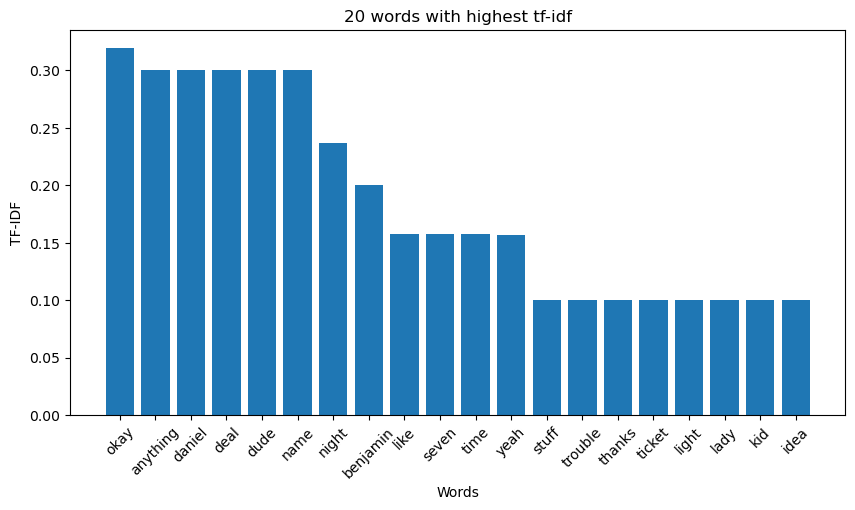





TF-IDF for 1:


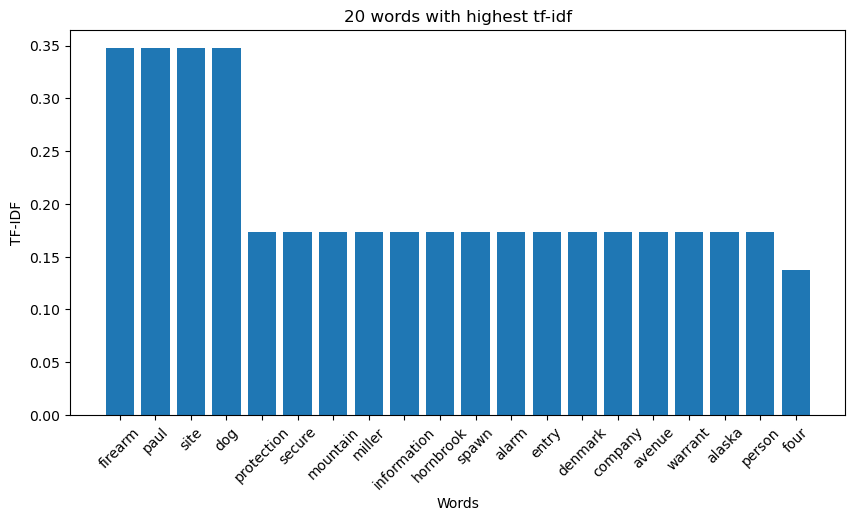





TF-IDF for 2:


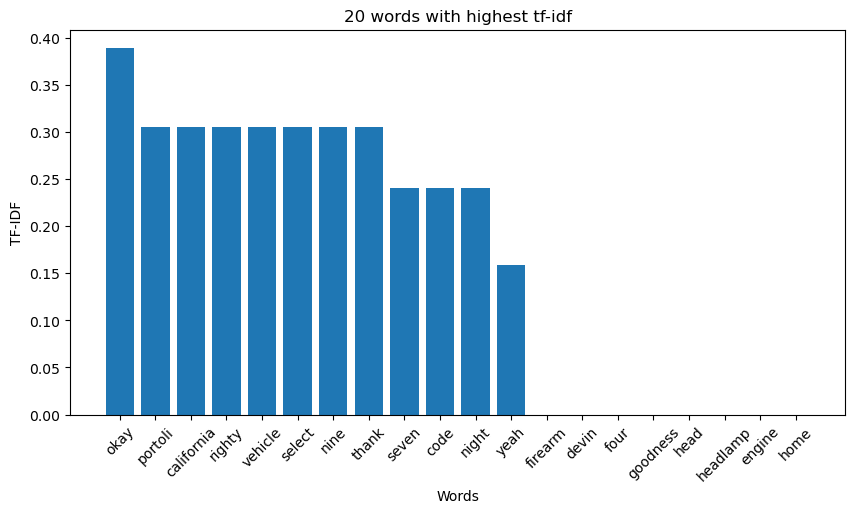





TF-IDF for 3:


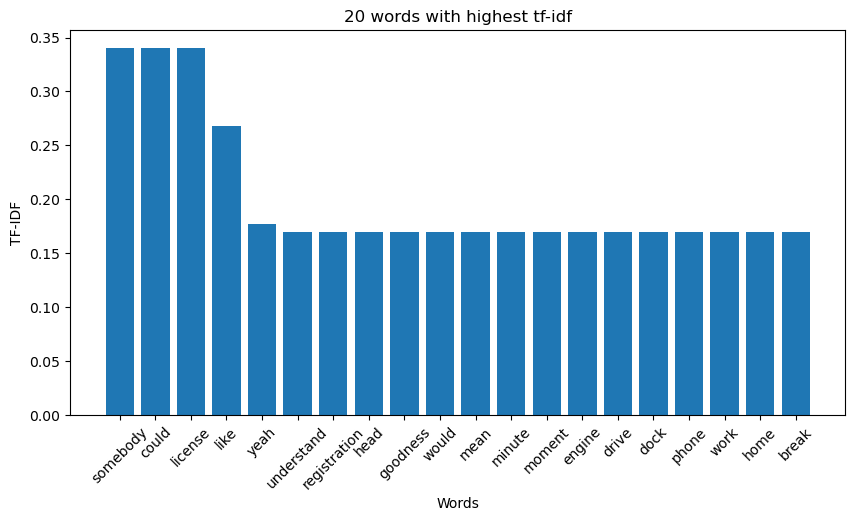

In [11]:
"""
This Python script processes a directory of text files, preprocesses the text in each file, calculates the TF-IDF (Term Frequency-Inverse Document Frequency) for each file, and outputs the 20 words with the highest TF-IDF in each file.

Functions:
- process_files(directory): Processes a directory of text files. For each text file, it reads the file, preprocesses the text, removes stopwords, and lemmatizes the words. It then calculates the TF-IDF for each file and prints the processed text and the TF-IDF. It also plots a bar chart of the 20 words with the highest TF-IDF in each file.

The script then processes a specified directory and outputs the processed text and TF-IDF for each text file in the directory.
"""

def process_files(directory):
    documents = []
    files = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                data = file.read()
                data = preprocess(data)
                data = stopword(data)
                data = lemmatizer(data)
                documents.append(data)
                files.append(filename)

    # Calculate TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(documents)

    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    # Print TF-IDF for each file
    for i, filename in enumerate(files):
        
        print("\n" + "="*50 + "\n")  # separator
        print(f"TF-IDF for {i}:")

        tfidf_sorting = np.argsort(X[i].toarray()).flatten()[::-1]
        top_n = tfidf_sorting[:20]
        top_features = [feature_names[j] for j in top_n]
        top_values = [X[i, j] for j in top_n]

        # Plotting
        plt.figure(figsize=(10,5))
        plt.bar(top_features, top_values)
        plt.title(f'20 words with highest tf-idf')
        plt.xlabel('Words')
        plt.ylabel('TF-IDF')
        plt.xticks(rotation=45)
        plt.show()

        print("\n" + "="*50 + "\n")  # separator

# Call the function with the path to your directory
process_files('/path/to/your/directory/')


# Directory level

In [10]:
def get_text(filepath):
    with open(filepath, encoding='utf-8') as f:
        text = f.read()
        return text

def zero_shot_classification(directory_name, pipe):
    for dirpath, dirnames, filenames in os.walk(directory_name):
        for filename in filenames:
            if filename.endswith(".txt"):
                text = get_text(dirpath + '/' +filename)
                print(filename)
                # Define the candidate labels
                setimental_labels = ['Positive', 'Neutral', 'Non Positive']
                toxic_labels = ['Toxic', 'Neutral','Non Toxic']
                racist_labels = ['Racist', 'Neutral','Non Racist']
                hateful_labels = ['Hateful', 'Neutral','Non Hateful']
                judging_labels = ['Judgemental', 'Neutral','Non Judgemental']


                # Use the pipeline to classify the text
                result = pipe(text, candidate_labels=setimental_labels)
                result1 = pipe(text, candidate_labels=toxic_labels)
                result2 = pipe(text, candidate_labels=racist_labels)
                result3 = pipe(text, candidate_labels=hateful_labels)
                result4 = pipe(text, candidate_labels=judging_labels)


                Positivity = dict(zip(result['labels'], result['scores']))
                Toxicity = dict(zip(result1['labels'], result1['scores']))
                Racism = dict(zip(result2['labels'], result2['scores']))
                Hateful = dict(zip(result3['labels'], result3['scores']))
                Judgemental = dict(zip(result4['labels'], result4['scores']))

                data = [Positivity, Toxicity, Racism, Hateful, Judgemental]

                # Initialize lists to store values
                non_list = []
                neutral_list = []
                positive_list = []

                # Iterate over data
                for d in data:
                    for key, value in d.items():
                        if 'Non' in key:
                            non_list.append(value)
                        elif 'Neutral' in key:
                            neutral_list.append(value)
                        else:
                            positive_list.append(value)

                index = ['Positive', 'Toxic', 'Racist', 'Hateful', 'Judgemental']
                # Create DataFrame
                df = pd.DataFrame({
                    'Yes': positive_list,
                    'Neutral': neutral_list,
                    'Not': non_list
                    }, index=index)
                print(df)

                final_result = df.idxmax(axis=1)
                print(final_result)

                pos_detect_list = [k for i in data for k in i.keys() if 'non' not in k.lower() and 'neutral' not in k.lower()]
                pos_detect_total = sum(d[key] for d in data for key in pos_detect_list if key in d)
                print(f"The total values for pos_detect is: {pos_detect_total}")

                key_non_list = [k for i in data for k in i.keys() if 'non' in k.lower()]
                non_total = sum(d[key] for d in data for key in key_non_list if key in d)
                print(f"The total values for neg_detect is: {non_total}")

                neutral_list = [k for i in data for k in i.keys() if 'neutral' in k.lower()]
                neutral_total = sum(d[key] for d in data for key in neutral_list if key in d)
                print(f"The total values for Neutral is: {neutral_total}")
